# COLAB 關聯 GOOGLE DRIVE

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 複製檔案到xx資料夾的語法

In [5]:
#! cp "/content/drive/My Drive/medical-masks-dataset.zip" /content/darknet

# 搬移資料夾語法

In [22]:
#! mv /content/mask_labels /content/darknet

# 解壓縮ZIP語法

In [6]:
#! unzip /content/darknet/medical-masks-dataset.zip > data_unzip.log

# 完成後確認 darknet資料夾下有
* mask_images資料夾(裡面是jpg檔)
* mask_labels資料夾(裡面是xml檔)
* yolo資料夾
 * 編號好的照片jpg檔及對應txt檔
* cfg_mask資料夾
 * weights資料夾(用來存放訓練好的weights)
 * darknet53.conv.74(預訓練好的模型)
 * obj.data
   * classes= 要訓練的類別數量
   * train  = train.txt路徑
   * valid  = test.txt路徑
   * names  = obj.names路徑
   * backup = weights資料夾路徑(訓練後weight會存在這)
 * obj.names
   * class1
   * class2
   * classN
 * test.txt(裡面是每張待test照片的路徑)
 * train.txt(裡面是每張待train照片的路徑)
 * yolov3-tiny.cfg(看要用甚麼模型)




#  ---------以下開始yolo_mask實作------------------------

# 下載darknet檔案

In [2]:
!git clone https://github.com/pjreddie/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 5913, done.
remote: Total 5913 (delta 0), reused 0 (delta 0), pack-reused 5913
Receiving objects: 100% (5913/5913), 6.34 MiB | 30.46 MiB/s, done.
Resolving deltas: 100% (3922/3922), done.


# 進入Makefile修改GPU=1,CUDNN=1,OPENCV=1

In [3]:
!cd darknet; head Makefile
!sed -i "s/GPU=0/GPU=1/g" darknet/Makefile
!sed -i "s/CUDNN=0/CUDNN=1/g" darknet/Makefile
!sed -i "s/OPENCV=0/OPENCV=1/g" darknet/Makefile
!head darknet/Makefile

GPU=0
CUDNN=0
OPENCV=0
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]
GPU=1
CUDNN=1
OPENCV=1
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]


# 編譯DARKNET

In [4]:
!cd darknet;make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN 

# 查看圖片是否正常

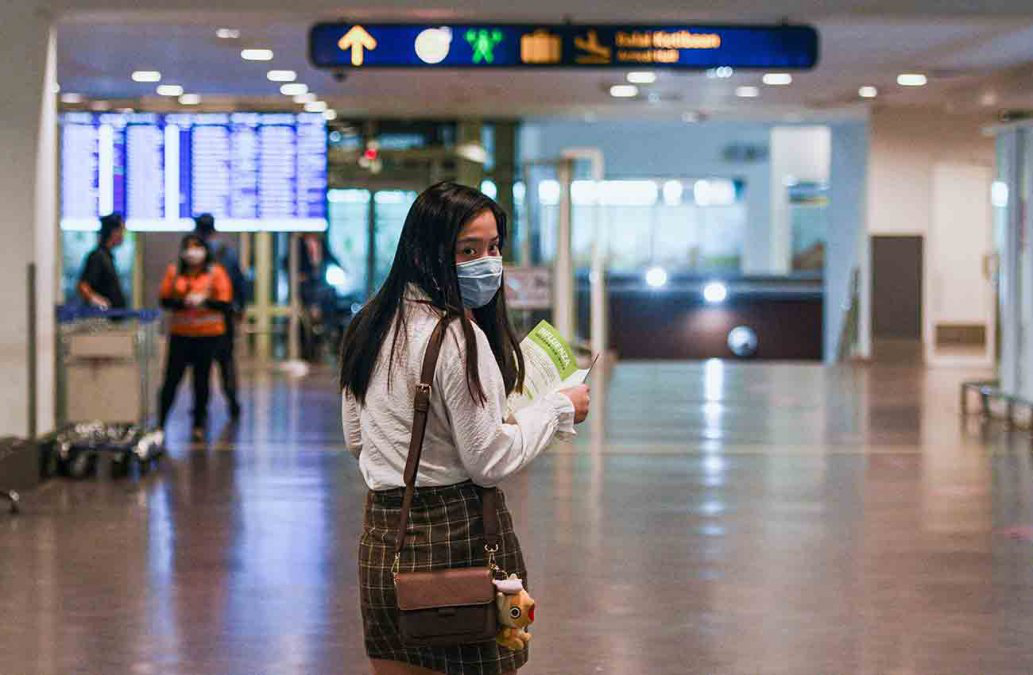

In [25]:
from PIL import Image
img = Image.open('/content/darknet/mask_images/0002526673.jpg')
img

# 查看對應xml檔label 是否正常

In [28]:
! cat /content/darknet/mask_labels/0002526673.xml

<annotation>
	<folder>images</folder>
	<filename>0002526673.jpg</filename>
	<path>P:\mask_mouth\images\0002526673.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1033</width>
		<height>675</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>good</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>452</xmin>
			<ymin>228</ymin>
			<xmax>505</xmax>
			<ymax>310</ymax>
		</bndbox>
	</object>
	<object>
		<name>good</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>179</xmin>
			<ymin>238</ymin>
			<xmax>207</xmax>
			<ymax>267</ymax>
		</bndbox>
	</object>
</annotation>


# 創建"yolo"資料夾(要用來放重新命名過的jpg檔及對應label的txt檔)
 * ps(txt檔是由原本的xml檔處理後得來的)

In [29]:
! rm -rf /content/darknet/yolo
! mkdir /content/darknet/yolo

# 定義getYoloFormat函數
1. 把類別轉成數字
2. 把mask_images裡的照片重新命名並存入名為"yolo"的資料夾
3. 把mask_labels裡的xml轉成txt檔並重新命名存入名為"yolo"的資料夾
4. image和label名稱會一一對應

In [30]:
from bs4 import BeautifulSoup
import os
import shutil

status_dic = {'good':2, 'bad':1, 'none':0}             #用dictionary 記錄label的名稱
def getYoloFormat(filename, label_path, img_path, yolo_path, newname):
  with open(label_path+filename, 'r') as f:
    soup = BeautifulSoup(f.read(), 'xml')
    imgname = soup.select_one('filename').text         #讀取xml
    image_w = soup.select_one('width').text
    image_h = soup.select_one('height').text
    ary = []
    for obj in soup.select('object'):                  #取出xmin, xmax, ymin, ymax及name
      xmin = int(obj.select_one('xmin').text)          #並且用status_dictionary 來轉換name，good =>2
      xmax = int(obj.select_one('xmax').text)
      ymin = int(obj.select_one('ymin').text)
      ymax = int(obj.select_one('ymax').text)
      objclass = status_dic.get(obj.select_one('name').text)

      x = (xmin + (xmax-xmin)/2) * 1.0 / float(image_w)    #YOLO吃的參數檔有固定的格式
      y = (ymin + (ymax-ymin)/2) * 1.0 / float(image_h)    #先照YOLO的格式訂好x,y,w,h
      w = (xmax-xmin) * 1.0 / float(image_w)
      h = (ymax-ymin) * 1.0 / float(image_h)
      ary.append(' '.join([str(objclass), str(x), str(y), str(w), str(h)]))
    if os.path.exists(img_path+imgname):                              # 圖片本來在image裡面，把圖片移到yolo資料夾下    
      shutil.copyfile(img_path+imgname, yolo_path+newname+'.jpg')     #同時把yolo參數檔寫到yolo之下

      with open(yolo_path+newname+'.txt', 'w') as f:
        f.write('\n'.join(ary))

# 呼叫getYoloFormat

In [31]:
import os
labelpath = '/content/darknet/mask_labels/'           #設定路徑
imgpath = '/content/darknet/mask_images/'
yolopath = '/content/darknet/yolo/'
ary = []
for idx, f in enumerate(os.listdir(labelpath)):   #透過getYoloFormat將圖像和參數檔全部寫到YOLO下
  try:
    getYoloFormat(f, labelpath, imgpath, yolopath, str(idx))
  except Exception as e:
    print(e)

float division by zero


# 觀察其中一張照片

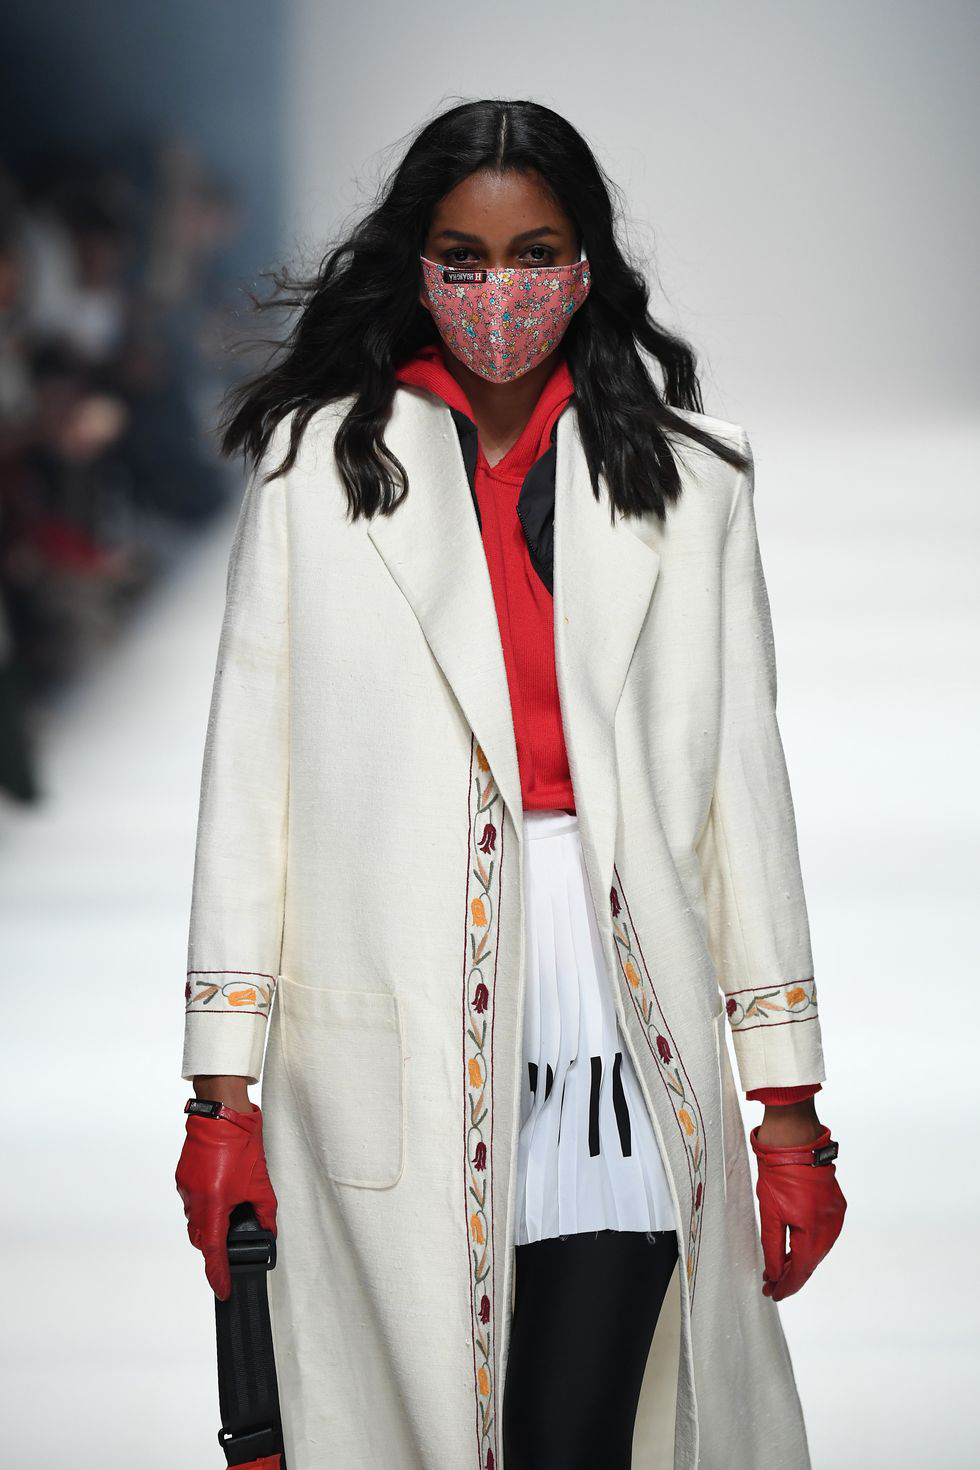

In [32]:
from PIL import Image
Image.open('/content/darknet/yolo/0.jpg')

# 觀察對應的標記檔

In [ ]:
! cat /content/yolo/0.txt

2 0.578 0.616 0.468 0.46

# 建立cfg_mask資料夾

In [33]:
! rm -rf /content/darknet/cfg_mask
! mkdir /content/darknet/cfg_mask

# 計算"yolo"資料夾中前80%的資料有多少(要做為訓練資料)

In [34]:
import os
datasets = ['/content/darknet/yolo/'+ f for f in os.listdir('/content/darknet/yolo/') if not f.endswith('.txt')]
len(datasets) * 0.8        #計算80%的資料有幾筆

541.6

# "yolo"資料夾前80%資料(540筆)寫入darknet/ cfg_mask/ train.txt

In [35]:
with open('/content/darknet/cfg_mask/train.txt', 'w') as f:
  f.write('\n'.join(datasets[0:540]))

# "yolo"資料夾中剩下的20%的資料作為測試資料集，寫入darknet/ cfg_mask/test.txt

In [36]:
with open('/content/darknet/cfg_mask/test.txt', 'w') as f:
  f.write('\n'.join(datasets[540:]))

# 按照固定格式生成obj.data和obj.names檔放到darknet/cfg_mask(可以用記事本寫，再重新命名)
* ps(這邊直接從雲端複製)

In [39]:
! cp "/content/drive/My Drive/obj.data" darknet/cfg_mask/
! cp "/content/drive/My Drive/obj.names" darknet/cfg_mask/

# 查看obj.data 資料

In [42]:
! head /content/darknet/cfg_mask/obj.data

classes= 3
train  = /content/darknet/cfg_mask/train.txt
valid  = /content/darknet/cfg_mask/test.txt
names  = /content/darknet/cfg_mask/obj.names
backup = /content/darknet/cfg_mask/weights/

# 查看obj.names 資料

In [41]:
! head /content/darknet/cfg_mask/obj.names

none
bad
good


# 建立weights資料夾

In [43]:
!mkdir /content/darknet/cfg_mask/weights

# 把yolov3-tiny.cfg複製到cfg_mask

In [44]:
!cp /content/darknet/cfg/yolov3-tiny.cfg /content/darknet/cfg_mask/

# 觀察模型cfg檔 filters跟classes

In [46]:
! sed -n -e 127p -e 135p -e 171p -e 177p /content/darknet/cfg_mask/yolov3-tiny.cfg

filters=255
classes=80
filters=255
classes=80


# 修改模型cfg檔參數
* yolov3的filter是 3*(classes + 5)

In [49]:
! sed -i '127s/255/24/' /content/darknet/cfg_mask/yolov3-tiny.cfg
! sed -i '135s/80/3/' /content/darknet/cfg_mask/yolov3-tiny.cfg
! sed -i '171s/255/24/' /content/darknet/cfg_mask/yolov3-tiny.cfg
! sed -i '177s/80/3/' /content/darknet/cfg_mask/yolov3-tiny.cfg

# 查看是否修改成功

In [50]:
! sed -n -e 127p -e 135p -e 171p -e 177p /content/darknet/cfg_mask/yolov3-tiny.cfg

filters=24
classes=3
filters=24
classes=3


# 下載Imagenet 訓練出來的 53 層預訓練模型

In [51]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-08-21 12:29:57--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   488KB/s    in 5m 49s  

2020-08-21 12:35:47 (455 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# 把預訓練模型darknet53.conv.74複製到cfg_mask資料夾下

In [52]:
! cp "/content/drive/My Drive/darknet53.conv.74" /content/darknet/cfg_mask/

# 訓練模型，每訓練100個就會把weight儲存到weight資料夾下

In [ ]:
!darknet/darknet detector train /content/darknet/cfg_mask/obj.data /content/darknet/cfg_mask/yolov3-tiny.cfg /content/darknet/cfg_mask/darknet53.conv.74

# 觀察原始照片

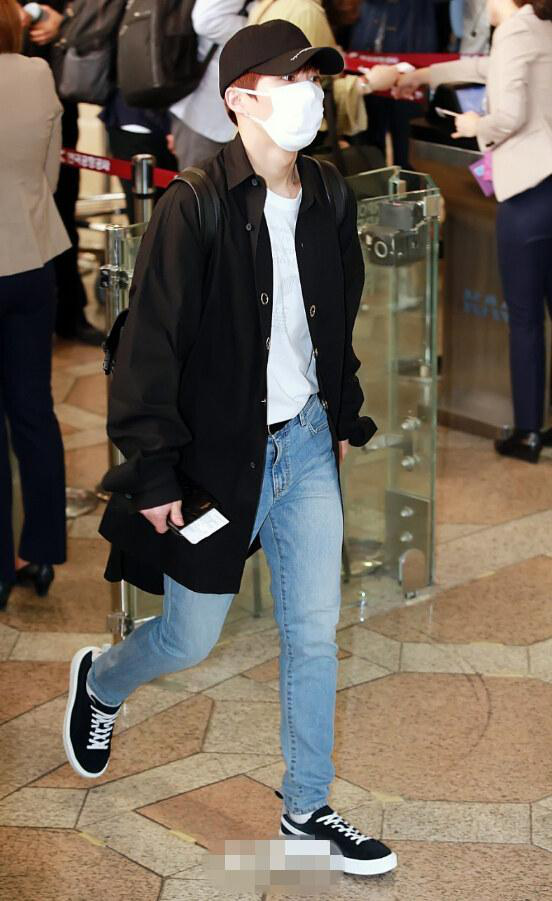

In [55]:
from PIL import Image
Image.open('darknet/yolo/605.jpg')

# 執行辨識

In [57]:
!cd darknet; ./darknet detector test /content/darknet/cfg_mask/obj.data /content/darknet/cfg_mask/yolov3-tiny.cfg /content/darknet/cfg_mask/weights/yolov3-tiny_20000.weights /content/darknet/test.jpg

layer     filters    size              input                output
    0 conv     16  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  16  0.150 BFLOPs
    1 max          2 x 2 / 2   416 x 416 x  16   ->   208 x 208 x  16
    2 conv     32  3 x 3 / 1   208 x 208 x  16   ->   208 x 208 x  32  0.399 BFLOPs
    3 max          2 x 2 / 2   208 x 208 x  32   ->   104 x 104 x  32
    4 conv     64  3 x 3 / 1   104 x 104 x  32   ->   104 x 104 x  64  0.399 BFLOPs
    5 max          2 x 2 / 2   104 x 104 x  64   ->    52 x  52 x  64
    6 conv    128  3 x 3 / 1    52 x  52 x  64   ->    52 x  52 x 128  0.399 BFLOPs
    7 max          2 x 2 / 2    52 x  52 x 128   ->    26 x  26 x 128
    8 conv    256  3 x 3 / 1    26 x  26 x 128   ->    26 x  26 x 256  0.399 BFLOPs
    9 max          2 x 2 / 2    26 x  26 x 256   ->    13 x  13 x 256
   10 conv    512  3 x 3 / 1    13 x  13 x 256   ->    13 x  13 x 512  0.399 BFLOPs
   11 max          2 x 2 / 1    13 x  13 x 512   ->    13 x  13 x 512
   12 con

# 查看辨識結果

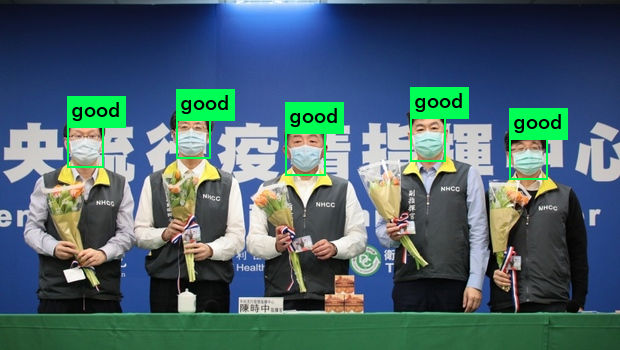

In [58]:
from PIL import Image
Image.open('/content/darknet/predictions.jpg')